<h1>
# CLASIFICADOR BINARIO :  PERROS VS GATOS. 

<hr>


SE CONSTRUYE UN MODELO DE RED NEURONAL CONVOLUCIONAL PARA DIFERENCIAR ENTRE UNA IMÁGEN DE UN GATO Y UNA IMÁGEN DE UN PERRO A PARTIR DE UN DATASET REDUCIDO CON 2000 IMAGENES PARA TRAIN Y 1000 PARA VALIDATION

In [1]:
from google.colab import files
import numpy as np
import random
import os
import zipfile

%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

from keras.preprocessing import image
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

# OBTENER EL DATASET

In [2]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \ -O /content/cats_and_dogs_filtered.zip

--2021-01-04 00:42:52--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.20.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   105MB/s    in 0.6s    

2021-01-04 00:42:53 (105 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]

--2021-01-04 00:42:53--  http://%20-o/
Resolving  -o ( -o)... failed: Name or service not known.
wget: unable to resolve host address ‘ -o’
/content/cats_and_dogs_filtered.zip: Scheme missing.
FINISHED --2021-01-04 00:42:53--
Total wall clock time: 1.0s
Downloaded: 1 files, 65M in 0.6s (105 MB/s)


In [3]:

local_zip = '/content/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content')
zip_ref.close()

In [4]:
path = '/content/cats_and_dogs_filtered'

train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')

# Carpetas de train
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Carpetas de validation 
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

print('\nNúmero de imágenes de gatos en train: ', len(os.listdir(      train_cats_dir ) ))
print('Número de imágenes de perros en train: ', len(os.listdir(      train_dogs_dir ) ))
print('\nNúmero de imágenes de gatos en validation: ', len(os.listdir( validation_cats_dir ) ))
print('Número de imágenes de perros en validation: ', len(os.listdir( validation_dogs_dir ) ))


Número de imágenes de gatos en train:  1000
Número de imágenes de perros en train:  1000

Número de imágenes de gatos en validation:  500
Número de imágenes de perros en validation:  500


# Nombres de las imágenes

In [5]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

[i for i in train_cat_fnames[:10]]

['cat.65.jpg',
 'cat.624.jpg',
 'cat.584.jpg',
 'cat.255.jpg',
 'cat.580.jpg',
 'cat.199.jpg',
 'cat.731.jpg',
 'cat.726.jpg',
 'cat.879.jpg',
 'cat.448.jpg']

# Mostrar algunas imágenes aleatorias

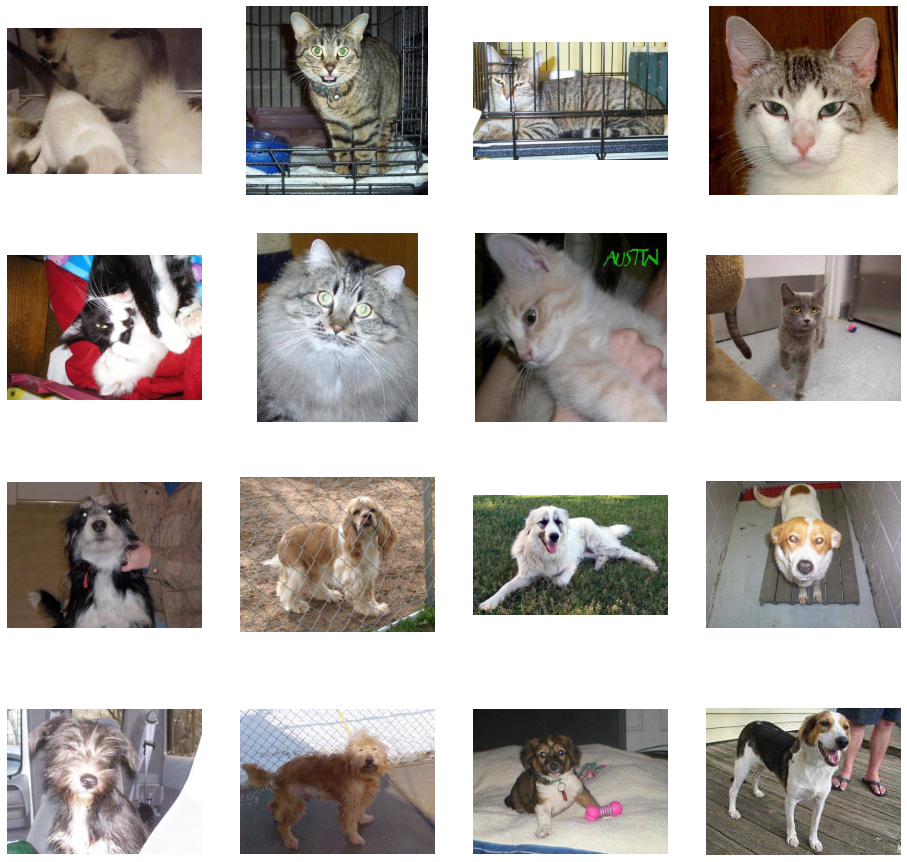

In [6]:
nrows = 4
ncols = 4

pic_index = 0 # Index para iterar a través de las imágenes

# Configurar matplotlib fig, y dimensionar a 4x4
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):

  # Configurar subplot, el índice comienza en 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# Generadores : 
Se construyen los generadores para acceder facilmente a las imágenes del dataset , además se aplica data augmentation para obtener más datos con diferentes perspectivas y así mejorar los resultados del entrenamiento.

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)#,
                                 #rotation_range=40,
                                 #width_shift_range=0.2,
                                 #height_shift_range=0.2,
                                 #shear_range=0.2,
                                 #zoom_range=0.2,
                                 #horizontal_flip=True,
                                 #fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(

                train_dir,
                target_size=(150,150),
                batch_size=10,
                class_mode='binary'   )      # clasificar entre perros y gatos

val_generator = val_datagen.flow_from_directory(

                validation_dir,
                target_size=(150,150),
                batch_size=10,
                class_mode='binary'   )      # clasificar entre perros y gatos

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Modelo:
Se construye una red neuronal convolucional desde cero y se tunean los hiperparámetros siguiendo las recomendación de la literatura hasta obtener resultados satisfactorios con relativamente pocos datos.

In [18]:
def model_CNN():

    model = tf.keras.models.Sequential([

        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
        tf.keras.layers.MaxPooling2D(2,2),
        
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')     ])

    return model

model = model_CNN()
model.summary()
model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=0.001), metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_98 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 15, 15, 256)      

# Entrenamiento del modelo

In [19]:
history = model.fit_generator(

            train_generator,
            steps_per_epoch=100,
            epochs=100,
            validation_data=val_generator,
            validation_steps=50,
            verbose=2             )

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
100/100 - 9s - loss: 0.7763 - acc: 0.5140 - val_loss: 0.6929 - val_acc: 0.4980
Epoch 2/100
100/100 - 8s - loss: 0.7037 - acc: 0.4890 - val_loss: 0.6888 - val_acc: 0.5220
Epoch 3/100
100/100 - 8s - loss: 0.6986 - acc: 0.5130 - val_loss: 0.6800 - val_acc: 0.5580
Epoch 4/100
100/100 - 8s - loss: 0.6960 - acc: 0.5460 - val_loss: 0.6872 - val_acc: 0.5280
Epoch 5/100
100/100 - 8s - loss: 0.7129 - acc: 0.5460 - val_loss: 0.6668 - val_acc: 0.6260
Epoch 6/100
100/100 - 8s - loss: 0.6956 - acc: 0.5590 - val_loss: 0.6783 - val_acc: 0.5760
Epoch 7/100
100/100 - 8s - loss: 0.6787 - acc: 0.5890 - val_loss: 0.6606 - val_acc: 0.5500
Epoch 8/100
100/100 - 8s - loss: 0.6940 - acc: 0.5770 - val_loss: 0.6522 - val_acc: 0.6540
Epoch 9/100
100/100 - 8s - loss: 0.6698 - acc: 0.5950 - val_loss: 0.6309 - val_acc: 0.6340
Epoch 10/100
100/100 - 8s - loss: 0.6882 - acc: 0.6200 - val_loss: 0.6257 - val_acc: 0.6080
Epoch 11/100
100/100 - 8s - loss: 0.6778 - acc: 0.6230 - val_loss: 0.6291 - val_acc: 0.63

# Gráfica del entrenamiento

<Figure size 432x288 with 0 Axes>

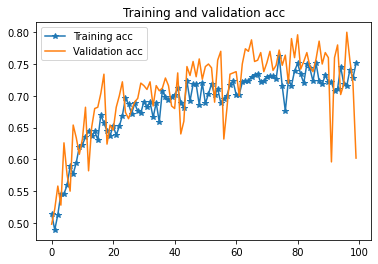

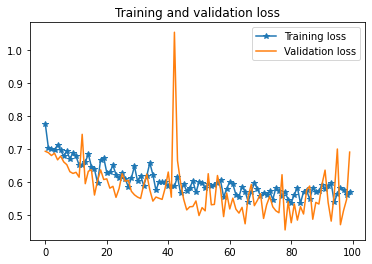

<Figure size 432x288 with 0 Axes>

In [20]:

acc      = history.history[     'acc' ]
val_acc  = history.history[ 'val_acc' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) 

#------------------------------------------------#
# Graficar training y validation accuracy        #
#------------------------------------------------#
plt.plot  ( epochs,     acc , '*-', label='Training acc' )
plt.plot  ( epochs, val_acc, label='Validation acc' )
plt.title ('Training and validation acc')
plt.legend()
plt.figure()


#------------------------------------------------#
# Graficar training and validation loss          #
#------------------------------------------------#
plt.plot  ( epochs,     loss , '*-', label='Training loss')
plt.plot  ( epochs, val_loss, label='Validation loss')
plt.title ('Training and validation loss'   )

plt.legend(loc='upper right')
plt.figure()


# Interpretabilidad del modelo: Visualizaciones intermedias.

Se observa el proceso por el cual cada capa convolucional obtiene información de una imágen aleatoria en el set de train.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


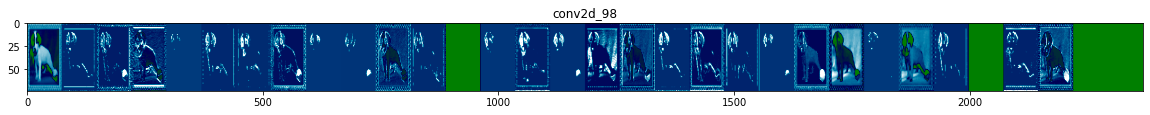

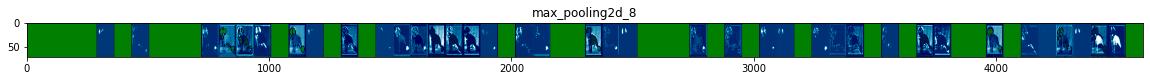

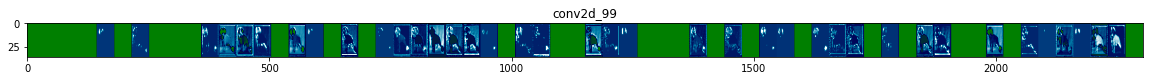

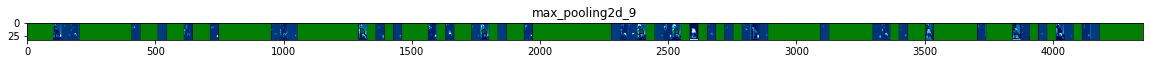

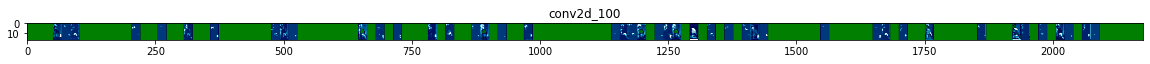

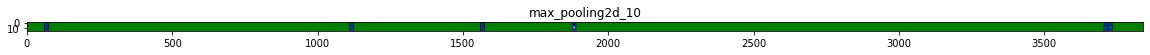

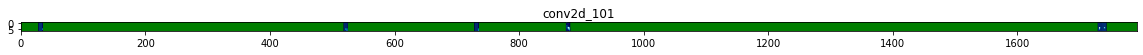

In [56]:
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Obtener una imágen aleatoria del set train y preprocesarla
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  

x   = img_to_array(img)                           # Numpy array con dimensiones (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array con dimensiones (1, 150, 150, 3)


x /= 255.0   # reescalar a 1/255

successive_feature_maps = visualization_model.predict(x)

# Obtener los nombres de cada capa para mostrarlos
layer_names = [layer.name for layer in model.layers]

# ------------------------------------------#
#    Ahora veamos las representaciones      #
# ------------------------------------------#
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-----------------------------------------------------------------------------#
    # Mostrar solo las capas convolucionales , no la red neuronal fully-conected  # 
    #-----------------------------------------------------------------------------#
    n_features = feature_map.shape[-1]  # numero de características en feature map
    size       = feature_map.shape[ 1]  # feature map dimensiones :  (1, size, size, n_features)
    

    # Matriz que contedrá las imágenes
    display_grid = np.zeros((size, size * n_features))
    

    #--------------------------------------------------------------------#
    # procesar las características para que sean visualmente agradables  #
    #--------------------------------------------------------------------#
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1 ) * size] = x 


    #---------------#
    #    Graficar   #
    #---------------#
    scale = 20./ n_features
    plt.figure( figsize=(scale* n_features , scale*2) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='ocean' ) 

# Predicciones

Saving gato1.jpg to gato1.jpg
Saving gato2.jpg to gato2.jpg
Saving gato3.jpg to gato3.jpg
Saving perro3.jpg to perro3.jpg
Saving perro2.jpg to perro2.jpg
Saving perro1.jpg to perro1.jpg


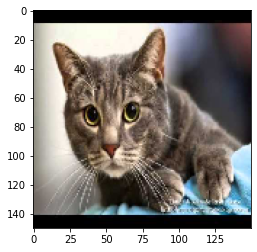

[1.]
gato1.jpg is a dog


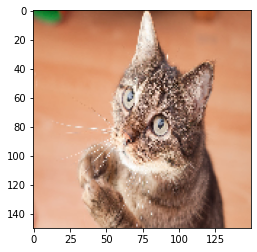

[0.]
gato2.jpg is a cat


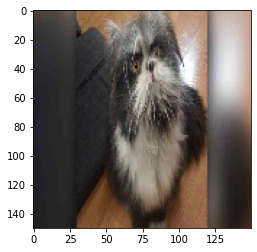

[0.]
gato3.jpg is a cat


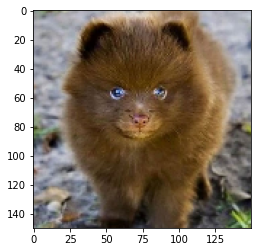

[1.]
perro3.jpg is a dog


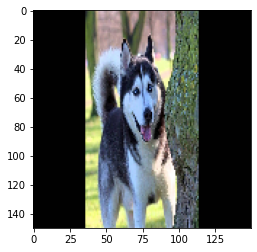

[1.]
perro2.jpg is a dog


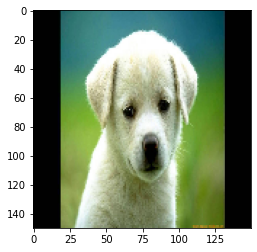

[1.]
perro1.jpg is a dog


In [12]:
uploaded=files.upload()

for fn in uploaded.keys():
 
  # Predicción de imágenes
  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150))
  
  plt.imshow(img)
  plt.show()

  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)
  
  print(classes[0])
  
  if classes[0]>0:
    print(fn + " is a dog")
    
  else:
    print(fn + " is a cat")
 

# Mejorando los resultados mediante tranfer-learning:

Se aplica el modelo pre-entrenado Inception-V3, mediante transferencia de aprendizaje se logran resultados cercanos al 97% de accuracy.

In [13]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  


local_weights_file = '/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  

pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2021-01-04 00:59:12--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.128, 74.125.20.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/content/inception_ 100%[===================>]  83.84M   153MB/s    in 0.5s    

2021-01-04 00:59:13 (153 MB/s) - ‘/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0           

In [14]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [15]:
history   = model.fit(
            train_generator,
            validation_data = val_generator,
            steps_per_epoch = 100,
            epochs = 50,
            validation_steps = 50,
            verbose = 2)

Epoch 1/50
100/100 - 13s - loss: 0.4170 - accuracy: 0.8280 - val_loss: 0.1288 - val_accuracy: 0.9520
Epoch 2/50
100/100 - 9s - loss: 0.2606 - accuracy: 0.8830 - val_loss: 0.1209 - val_accuracy: 0.9600
Epoch 3/50
100/100 - 9s - loss: 0.2277 - accuracy: 0.9120 - val_loss: 0.1464 - val_accuracy: 0.9500
Epoch 4/50
100/100 - 9s - loss: 0.2432 - accuracy: 0.9190 - val_loss: 0.1906 - val_accuracy: 0.9420
Epoch 5/50
100/100 - 9s - loss: 0.2582 - accuracy: 0.9210 - val_loss: 0.1348 - val_accuracy: 0.9640
Epoch 6/50
100/100 - 9s - loss: 0.2506 - accuracy: 0.9220 - val_loss: 0.1609 - val_accuracy: 0.9560
Epoch 7/50
100/100 - 9s - loss: 0.2015 - accuracy: 0.9330 - val_loss: 0.1425 - val_accuracy: 0.9560
Epoch 8/50
100/100 - 9s - loss: 0.2629 - accuracy: 0.9170 - val_loss: 0.1009 - val_accuracy: 0.9720
Epoch 9/50
100/100 - 9s - loss: 0.1782 - accuracy: 0.9330 - val_loss: 0.1152 - val_accuracy: 0.9600
Epoch 10/50
100/100 - 9s - loss: 0.1777 - accuracy: 0.9400 - val_loss: 0.0841 - val_accuracy: 0.964

<Figure size 432x288 with 0 Axes>

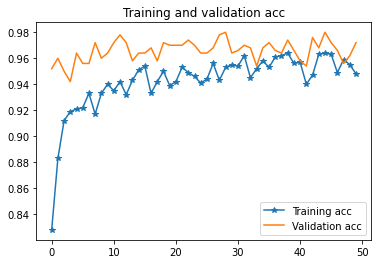

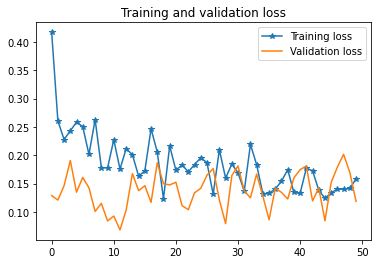

<Figure size 432x288 with 0 Axes>

In [17]:
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) 

#------------------------------------------------#
# Graficar training y validation accuracy        #
#------------------------------------------------#
plt.plot  ( epochs,     acc , '*-', label='Training acc' )
plt.plot  ( epochs, val_acc, label='Validation acc' )
plt.title ('Training and validation acc')
plt.legend()
plt.figure()


#------------------------------------------------#
# Graficar training and validation loss          #
#------------------------------------------------#
plt.plot  ( epochs,     loss , '*-', label='Training loss')
plt.plot  ( epochs, val_loss, label='Validation loss')
plt.title ('Training and validation loss'   )

plt.legend(loc='upper right')
plt.figure()
